<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение 2
### Семинар 1. Полносвязная нейронная сеть

<br />
<br />
17 февраля 2022

В этом задании мы реализуем и потренируем настоящую нейроную сеть своими руками, «from scratch»!

Нам нужно будет просто составить несколько линейных классификаторов вместе :)

<center><img src="./images/more_layers.png" width=400></center> 


In [1]:
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.io as scipyio
import urllib.request

from copy import deepcopy

%load_ext autoreload
%autoreload 2

### Загружаем и «готовим» данные

In [2]:
def load_data_mat(path_to_file, max_samples, seed=7):
#     with urllib.request.urlopen(url) as url, io.open('tmp.mat', 'wb+') as tmp_file:
#         raw_bytes = url.read()
#         tmp_file.write(raw_bytes)

    # load data to your machine and then
    with io.open(path_to_file, 'rb+') as tmp_file:
        raw_mat = scipyio.loadmat(tmp_file)
    
    X = raw_mat['X']  # Array of [32, 32, 3, n_samples]
    y = raw_mat['y']  # Array of [n_samples, 1]
    X = np.moveaxis(X, [3], [0])
    y = y.flatten()
    # Fix up class 0 to be 0
    y[y == 10] = 0
    
    np.random.seed(seed)
    samples = np.random.choice(np.arange(X.shape[0]),
                               max_samples,
                               replace=False)
    
    return X[samples].astype(np.float32), y[samples]


In [3]:
#! wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
#! wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2022-02-16 16:16:55--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  8.12MB/s    in 37s     

2022-02-16 16:17:32 (4.67 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2022-02-16 16:17:32--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  3.67MB/s    in 24s     

2022-02-16 16:17:56 (2.60 MB/s) - ‘test_32x32.mat.1’ saved [642

In [4]:
%%time
# from http://ufldl.stanford.edu/housenumbers/train_32x32.mat
train_X, train_y = load_data_mat('train_32x32.mat', max_samples=10000)

CPU times: user 1.93 s, sys: 369 ms, total: 2.3 s
Wall time: 2.6 s


In [5]:
%%time
# from http://ufldl.stanford.edu/housenumbers/test_32x32.mat
test_X, test_y = load_data_mat('test_32x32.mat', max_samples=1000)

CPU times: user 682 ms, sys: 112 ms, total: 795 ms
Wall time: 881 ms


In [6]:
train_X.shape

(10000, 32, 32, 3)

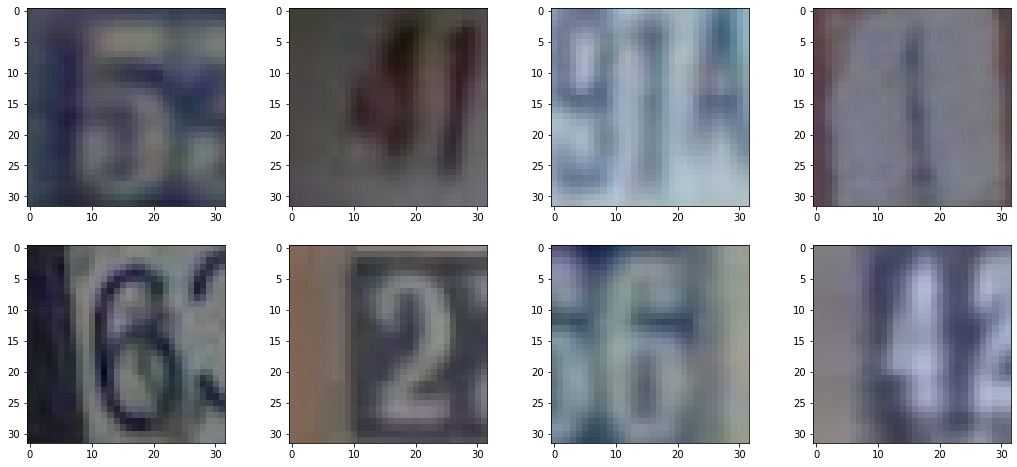

In [7]:
fig, gs = plt.figure(figsize=(18, 8)), matplotlib.gridspec.GridSpec(2, 4)

for i in range(8):
    plot = fig.add_subplot(gs[i])
    plot.imshow(train_X[i].astype(int))

plt.show()

In [8]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # minus mean for centering
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat

def random_split_train_val(X, y, num_val, seed=42):
    np.random.seed(seed)

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y


И ещё разделяем данные на training и validation

In [9]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)

# split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val=1000)

In [10]:
train_X.shape

(9000, 3072)

### Обязательно будем себя проверять

Вообще в этой части курса мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений — собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    r"""
    Computes function and analytic gradient at `x`
    
    Parameters
    ----------
    x : ndarray of float
      Input to the function
    
    Returns
    -------
    value : float
      Value of the function 
    grad : ndarray of float
      Same shape as `x`
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Для проверки мы будем использовать функции, которые вычисляют градиент с помощью численной производной для каждой координаты. Для вычисления производной используем так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

$$ \frac{f(x+\delta)-f(x-\delta)}{2\delta}$$

In [11]:
def check_gradient(f, x, delta=1e-5, tol=1e-4):
    r"""
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula

    Parameters
    ----------
    f 
      Function that receives `x` and computes value and gradient
    x : ndarray
      Initial point where gradient is checked
    delta : float
      Step to compute numerical gradient
    tol: float 
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float64

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()

    assert analytic_grad.shape == x.shape

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = 0

        delta_array = np.zeros(x.shape)
        delta_array[ix] = delta
        fx_add_delta, _ = f(x + delta_array)
        fx_sub_delta, _ = f(x - delta_array)

        numeric_grad_at_ix = (fx_add_delta - fx_sub_delta) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
                  ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    r"""
    Checks gradient correctness for the input and output of a layer

    Parameters
    ----------
    layer 
      Neural network layer, with forward and backward functions
    x
      Starting point for layer input
    delta : float
      Step to compute numerical gradient
    tol : float
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)


def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    r"""
    Checks gradient correctness for the parameter of the layer

    Parameters
    ----------
    layer
      Neural network layer, with forward and backward functions
    x
      Starting point for layer input
    param_name
      Name of the parameter
    delta : float
      Step to compute numerical gradient
    tol : float
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)


def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters

    Parameters
    ----------
    model
      Neural network model with compute_loss_and_gradients
    X : ndarray
      Batch of input data
    y : ndarray
      Batch of labels
    delta : float 
      Step to compute numerical gradient
    tol : float
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True


### Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с `ReLU`, у которого параметров нет.

In [12]:
class ReLULayer:
    def __init__(self):
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        return ...

    def backward(self, d_out):
        r"""
        Backward pass

        Parameters
        ----------
        d_out : ndarray, shape(batch_size, num_features)
            Gradient of loss function with respect to output

        Returns
        -------
        d_result : ndarray, shape(batch_size, num_features)
            Gradient with respect to input
        """
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops
        return ...

    def params(self):
        # ReLU Doesn't have any parameters
        return {}


In [13]:
# DONE: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из `cross-entropy loss` и `regularization loss`.

In [14]:
class Param:
    r"""
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(self.value)


In [15]:
class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
#         self.W = Param(np.random.normal(0, sqrt(2 / n_input), (n_input, n_output)))
#         self.B = Param(np.random.normal(0, sqrt(2 / n_input), n_output))
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Your final implementation shouldn't have any loops
        self.X = deepcopy(X)

        return ...

    def backward(self, d_out):
        r"""
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B

        Parameters
        ----------
        d_out, ndarray of shape(batch_size, n_output)
          Gradient of loss function with respect to output

        Returns
        -------
        d_result : ndarray of shape(batch_size, n_input) 
          Gradient with respect to input
        """
        # TODO: Implement backward pass
        # Compute both gradient with respect to input
        # and gradients with respect to W and B
        # Add gradients of W and B to their `grad` attribute
        
        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}


In [16]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


### Вспомогательные функции для реализации нейросети

In [17]:
def convert_1d_to_2d_array(array):
    r"""Util function to convert array"""
    if(array.ndim == 1):
        return array[np.newaxis, :].copy()
    else:
        return array.copy()

def softmax_with_cross_entropy(predictions, target_index):
    r"""Computes softmax and cross-entropy loss for model predictions,
    including the gradient.

    Parameters
    ----------
    predictions : ndarray, shape(num_classes) or shape(batch_size, num_classes)
        Classifier output.
    target_index : ndarray, shape(1) or shape(batch_size)
        Index(indices) of the true class(es) for given sample(s).

    Returns
    -------
    loss : float
        Computed cross-entropy loss value.
    dpredictions : ndarray
        Array, with the same shape as `predictions`. Gradient of loss value
        with respect to predictions.
    """
    # TODO: implement softmax_with_cross_entropy
    # Your final implementation shouldn't have any loops
    assert isinstance(predictions, np.ndarray)

    is_1D = (predictions.ndim == 1)
    predictions = convert_1d_to_2d_array(predictions)
    batch_size = predictions.shape[0]

    predictions -= np.max(predictions, axis=1)[:, np.newaxis]
    predictions = np.exp(predictions)

    probs = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

    dprediction = probs.copy()
    dprediction[(np.arange(batch_size), target_index)] -= 1
    dprediction /= batch_size
    if (is_1D):
        dprediction = np.squeeze(dprediction, axis=0)

    loss_arr = -np.log(probs)
    loss = np.sum(loss_arr[(np.arange(batch_size), target_index)]) / batch_size
    return loss, dprediction
    

def l2_regularization(W, reg_strength):
    r"""Computes L2 regularization loss on weights and its gradient.

    Parameters
    ----------
    W : ndarray, shape(num_features, num_classes)
        Weights.
    reg_strength : float
        Strength of regularization.

    Returns
    -------
    loss : float
        L2 regularization loss.
    gradient : ndarray, shape(num_features, num_classes)
        Gradient of L2 loss value with respect to weights.
    """
    # TODO: implement l2_regularization
    # Your final implementation shouldn't have any loops

    return loss, grad


### Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [18]:
class TwoLayerNet:
    r""" Neural network with two fully connected layers """

    def __init__(self, n_input, n_output, hidden_layer_size, reg):
        r"""
        Initializes the neural network

        Parameters
        ----------
        n_input : int 
          Dimension of the model input
        n_output : int
          Number of classes to predict
        hidden_layer_size : int
          Number of neurons in the hidden layer
        reg : float
          L2 regularization strength
        """
        self.reg = reg
        # TODO Create necessary layers
        self.layers = [
            FullyConnectedLayer(n_input, hidden_layer_size),
            ReLULayer(),
            FullyConnectedLayer(hidden_layer_size, n_output),
        ]

    def compute_loss_and_gradients(self, X, y):
        r"""
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Parameters
        ----------
        X : ndarray of shape(batch_size, input_features)
          Input data
        y : ndarray of shape(batch_size) of int
          Class labels
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!

        params = self.params()
        
        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model

        last_output = self.layers[0].forward(X)
        for layer in self.layers[1:]:
            last_output = layer.forward(last_output)

        loss, d_loss = softmax_with_cross_entropy(last_output, y)

        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!
        for param_name, param in params.items():
            reg_val, reg_grad = l2_regularization(param.value, self.reg)
            param.grad += reg_grad
            loss += reg_val
        return loss

    def predict(self, X):
        r"""
        Produces classifier predictions on the set

        Parameters
        ----------
          X : ndarray of shape(test_samples, num_features)

        Returns
        -------
          y_pred : ndarray of shape(test_samples) of int
        """
        # TODO: Implement predict
        # Hint: some of the code of the compute_loss_and_gradients
        # can be reused
        return pred

    def params(self):
        result = {}

        # TODO Implement aggregating all of the params
        counter = 1
        for layer in self.layers:
            new_params = layer.params()
            if new_params:
                result['W_{}'.format(counter)] = new_params['W']
                result['B_{}'.format(counter)] = new_params['B']
                counter += 1
        return result


In [19]:
# TODO: In TwoLayerNet, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO: Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию — она должна прибавляться к loss и делать свой вклад в градиенты.

In [20]:
# TODO: Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=3, reg=1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [21]:
def multiclass_accuracy(prediction, ground_truth):
    r"""
    Computes metrics for multiclass classification

    Parameters
    ----------
    prediction : ndarray of shape(num_samples) of int
      Model predictions
    ground_truth : ndarray of shape(num_samples) of int
      True labels

    Returns
    -------
    accuracy
      Ratio of accurate predictions to total samples
    """
    N = prediction.size
    accuracy = np.sum(prediction == ground_truth) / N
    
    return accuracy

In [22]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.13333333333333333

In [23]:
model_with_reg.predict(train_X[:30])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [24]:
class Dataset:
    r"""
    Utility class to hold training and validation data
    """

    def __init__(self, train_X, train_y, val_X, val_y):
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y


class Trainer:
    r"""
    Trainer of the neural network models
    Perform mini-batch SGD with the specified data, model,
    training parameters and optimization rule
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=1000,
                 learning_rate=1e-2,
                 learning_rate_decay=1.0):
        r"""
        Initializes the trainer

        Parameters
        ----------
        model
          Neural network model
        dataset : instance of Dataset class
          Data to train on
        optim
          Optimization method
        num_epochs : int
          Number of epochs to train
        batch_size : int
        learning_rate : float
          Initial learning rate
        learning_rate_decay : float
          Ratio for decaying learning rate every epoch
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay

        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        """
        Computes accuracy on provided data using mini-batches
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self):
        r"""
        Trains a model
        """
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            print('Started epoch {} / {}'.format(epoch, self.num_epochs))
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                # TODO: Generate batches based on batch_indices and
                # use model to generate loss and gradients for all the params

                X_batch = self.dataset.train_X[batch_indices]
                y_batch = self.dataset.train_y[batch_indices]

                loss = self.model.compute_loss_and_gradients(X_batch, y_batch)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

            if np.not_equal(self.learning_rate_decay, 1.0):
                # TODO: Implement learning rate decay
                pass 
            
            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X,
                                                   self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X,
                                                 self.dataset.val_y)

            print("\tLoss: %f, Train accuracy: %f, val accuracy: %f" %
                  (batch_losses[-1], train_accuracy, val_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history


In [25]:
class SGD:
    r"""
    Implements vanilla SGD update
    """
    def update(self, w, d_w, learning_rate):
        r"""
        Performs SGD update

        Parameters
        ----------
        w : ndarray
          Weights
        d_w : ndarray 
          Same shape as w — gradient
        learning_rate : float
          Learning rate

        Returns
        -------
        updated_weights : ndarray, same shape as w
        """
        return w - d_w * learning_rate


class MomentumSGD:
    r"""
    Implements Momentum SGD update
    """
    def __init__(self, momentum=0.9):
        self.momentum = momentum
        self.velocity = 0
    
    def update(self, w, d_w, learning_rate):
        r"""
        Performs Momentum SGD update

        Parameters
        ----------
        w : ndarray
          Weights
        d_w : ndarray, same shape as w
          Gradient
        learning_rate : float
          Learning rate

        Returns
        -------
        updated_weights : ndarray same shape as w
        """
        # TODO Implement momentum update
        # Hint: you'll need to introduce some variables to remember
        # velocity from the previous updates
        #self.velocity = 
        return w + self.velocity


In [26]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), num_epochs=20, learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 20
	Loss: 2.301323, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 1 / 20
	Loss: 2.299574, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 2 / 20
	Loss: 2.298589, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 20
	Loss: 2.297205, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 20
	Loss: 2.295666, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 20
	Loss: 2.295286, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 20
	Loss: 2.292073, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 20
	Loss: 2.293546, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 20
	Loss: 2.292244, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 20
	Loss: 2.289731, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 20
	Loss: 2.288544, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 11 / 20
	Loss: 2.288047, Tra

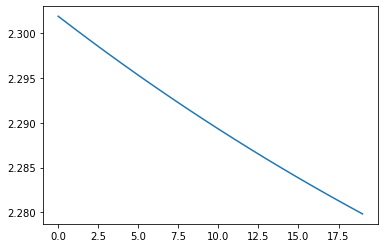

In [27]:
plt.plot(loss_history)

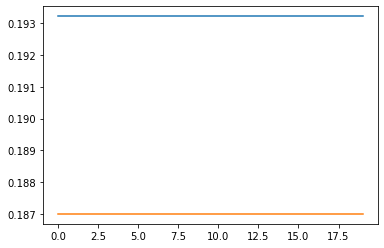

In [28]:
plt.plot(train_history)
plt.plot(val_history)

### Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

### Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей — постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов — уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [29]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Started epoch 0 / 20
	Loss: 2.331193, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 1 / 20
	Loss: 2.329046, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 2 / 20
	Loss: 2.327029, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 20
	Loss: 2.324533, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 20
	Loss: 2.321770, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 20
	Loss: 2.321109, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 20
	Loss: 2.318300, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 20
	Loss: 2.317881, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 20
	Loss: 2.314822, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 20
	Loss: 2.314494, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 20
	Loss: 2.313154, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 11 / 20
	Loss: 2.312101, Tra

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций — использование более эффективных методов градиентного спуска. Мы реализуем один из них — накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон — 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [30]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 20
	Loss: 2.333546, Train accuracy: 0.080222, val accuracy: 0.065000
Started epoch 1 / 20
	Loss: 2.333367, Train accuracy: 0.104444, val accuracy: 0.091000
Started epoch 2 / 20
	Loss: 2.333138, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 20
	Loss: 2.332902, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 20
	Loss: 2.332708, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 20
	Loss: 2.332365, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 20
	Loss: 2.332219, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 20
	Loss: 2.331922, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 20
	Loss: 2.331894, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 20
	Loss: 2.331315, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 20
	Loss: 2.331428, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 11 / 20
	Loss: 2.330992, Tra

### Ну что, давайте уже тренировать сеть!

### Финальный тест — переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно — переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [31]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 150
	Loss: 2.327862, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 1 / 150
	Loss: 2.312831, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 2 / 150
	Loss: 2.319310, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 3 / 150
	Loss: 2.281761, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 4 / 150
	Loss: 2.340438, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 5 / 150
	Loss: 2.319203, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 6 / 150
	Loss: 2.339462, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 7 / 150
	Loss: 2.176484, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 8 / 150
	Loss: 2.231060, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 9 / 150
	Loss: 1.945524, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 10 / 150
	Loss: 2.130711, Train accuracy: 0.333333, val accuracy: 0.200000
Started epoch 11 / 150
	Loss: 1

	Loss: 1.211571, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 96 / 150
	Loss: 0.953149, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 97 / 150
	Loss: 1.708824, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 98 / 150
	Loss: 1.408219, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 99 / 150
	Loss: 1.220649, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 100 / 150
	Loss: 1.376782, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 101 / 150
	Loss: 1.356982, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 102 / 150
	Loss: 1.666348, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 103 / 150
	Loss: 1.580462, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 104 / 150
	Loss: 1.203810, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 105 / 150
	Loss: 1.335288, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 106 / 150
	Loss: 1.43037

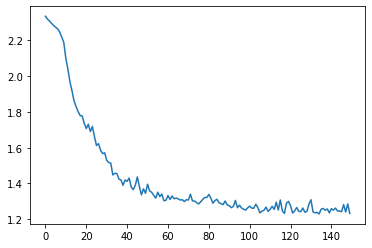

In [32]:
plt.plot(loss_history)

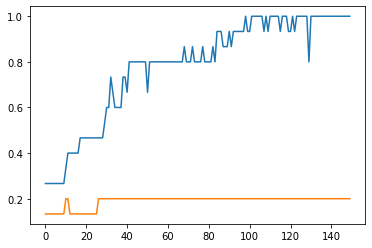

In [33]:
plt.plot(train_history)
plt.plot(val_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.

In [34]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=200, reg = 0.01)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# DONE: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(momentum=0.9), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 20
	Loss: 2.314706, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 1 / 20
	Loss: 2.232818, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 2 / 20
	Loss: 2.199285, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 3 / 20
	Loss: 2.417638, Train accuracy: 0.333333, val accuracy: 0.133333
Started epoch 4 / 20
	Loss: 1.782753, Train accuracy: 0.400000, val accuracy: 0.133333
Started epoch 5 / 20
	Loss: 1.710557, Train accuracy: 0.466667, val accuracy: 0.133333
Started epoch 6 / 20
	Loss: 1.343691, Train accuracy: 0.533333, val accuracy: 0.133333
Started epoch 7 / 20
	Loss: 0.963991, Train accuracy: 0.600000, val accuracy: 0.200000
Started epoch 8 / 20
	Loss: 0.872976, Train accuracy: 0.733333, val accuracy: 0.133333
Started epoch 9 / 20
	Loss: 1.640562, Train accuracy: 0.800000, val accuracy: 0.200000
Started epoch 10 / 20
	Loss: 0.598284, Train accuracy: 0.800000, val accuracy: 0.200000
Started epoch 11 / 20
	Loss: 0.669417, Tra

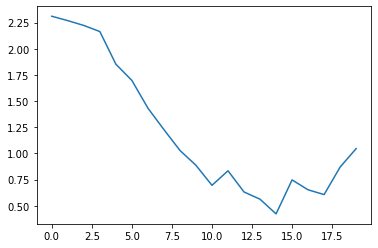

In [35]:
plt.plot(loss_history)

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Можно добиться точности лучше **60%** на validation set.

In [36]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 200
num_epochs = 100
batch_size = 1000

params_list = [
    {'learning_rate': 1e-4, 'reg_strength': 1e-1, 'learning_rate_decay': 0.9},
]

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X, train_y, val_X, val_y)
best_classifier_history = None
best_params = None
best_trainer = None

for param in params_list:
    print('\nStarted learning with new params\n')
    current_lr = param['learning_rate']
    current_reg_str = param['reg_strength']
    current_lr_decay = param['learning_rate_decay']

    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = current_reg_str)
    trainer = Trainer(model, dataset, MomentumSGD(momentum=0.9), learning_rate=current_lr, num_epochs=num_epochs,
                    batch_size=batch_size, learning_rate_decay=current_lr_decay)

    loss_history, train_history, val_history = trainer.fit()
    
    if best_val_accuracy is None:
        best_val_accuracy = max(val_history)
        best_classifier = model
        best_classifier_history = (loss_history, train_history, val_history)
        best_params = param
        best_trainer = trainer
        print('\nFirst best_val_accuracy: {}'.format(best_val_accuracy))
        print('Params init {}'.format(param))
        
    else:
        if max(val_history) > best_val_accuracy:
            best_val_accuracy = max(val_history)
            best_classifier = model
            best_classifier_history = (loss_history, train_history, val_history)
            best_params = param
            best_trainer = trainer
            print('\nNew best_val_accuracy: {}'.format(best_val_accuracy))
            print('New params: {}'.format(param))

print('\nContinue training best model with params: {}\n'.format(best_params))
loss_history, train_history, val_history = best_trainer.fit()

best_classifier_history[0].extend(loss_history)
best_classifier_history[1].extend(train_history)
best_classifier_history[2].extend(val_history)

best_val_accuracy = max(best_classifier_history[2])

print('\nbest validation accuracy achieved: %f' % best_val_accuracy)


Started learning with new params

Started epoch 0 / 100
	Loss: 2.303304, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 1 / 100
	Loss: 2.303282, Train accuracy: 0.135667, val accuracy: 0.150000
Started epoch 2 / 100
	Loss: 2.303115, Train accuracy: 0.142333, val accuracy: 0.157000
Started epoch 3 / 100
	Loss: 2.303013, Train accuracy: 0.142333, val accuracy: 0.157000
Started epoch 4 / 100
	Loss: 2.302853, Train accuracy: 0.142333, val accuracy: 0.157000
Started epoch 5 / 100
	Loss: 2.302735, Train accuracy: 0.142556, val accuracy: 0.157000
Started epoch 6 / 100
	Loss: 2.302457, Train accuracy: 0.176444, val accuracy: 0.168000
Started epoch 7 / 100
	Loss: 2.302429, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 100
	Loss: 2.302369, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 100
	Loss: 2.302199, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 100
	Loss: 2.302089, Train accuracy: 0.193222, val accuracy: 0.187

	Loss: 2.292537, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 93 / 100
	Loss: 2.291061, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 94 / 100
	Loss: 2.294963, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 95 / 100
	Loss: 2.292004, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 96 / 100
	Loss: 2.291364, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 97 / 100
	Loss: 2.290107, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 98 / 100
	Loss: 2.291603, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 99 / 100
	Loss: 2.292056, Train accuracy: 0.193222, val accuracy: 0.187000

First best_val_accuracy: 0.187
Params init {'learning_rate': 0.0001, 'reg_strength': 0.001, 'learning_rate_decay': 0.999}

Started learning with new params

Started epoch 0 / 100
	Loss: 2.363944, Train accuracy: 0.160000, val accuracy: 0.155000
Started epoch 1 / 100
	Loss: 2.363600, Train accuracy: 0.193222, 

	Loss: 2.339596, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 84 / 100
	Loss: 2.339017, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 85 / 100
	Loss: 2.339646, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 86 / 100
	Loss: 2.339669, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 87 / 100
	Loss: 2.338365, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 88 / 100
	Loss: 2.340285, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 89 / 100
	Loss: 2.337344, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 90 / 100
	Loss: 2.337320, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 91 / 100
	Loss: 2.338526, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 92 / 100
	Loss: 2.337869, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 93 / 100
	Loss: 2.337572, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 94 / 100
	Loss: 2.337429, Trai

	Loss: 1.979302, Train accuracy: 0.307444, val accuracy: 0.310000
Started epoch 76 / 100
	Loss: 1.889093, Train accuracy: 0.314889, val accuracy: 0.308000
Started epoch 77 / 100
	Loss: 1.966419, Train accuracy: 0.319556, val accuracy: 0.309000
Started epoch 78 / 100
	Loss: 1.932496, Train accuracy: 0.324667, val accuracy: 0.317000
Started epoch 79 / 100
	Loss: 1.956800, Train accuracy: 0.330778, val accuracy: 0.319000
Started epoch 80 / 100
	Loss: 1.916688, Train accuracy: 0.340333, val accuracy: 0.327000
Started epoch 81 / 100
	Loss: 1.893913, Train accuracy: 0.348444, val accuracy: 0.329000
Started epoch 82 / 100
	Loss: 1.837605, Train accuracy: 0.359333, val accuracy: 0.333000
Started epoch 83 / 100
	Loss: 1.883778, Train accuracy: 0.365889, val accuracy: 0.338000
Started epoch 84 / 100
	Loss: 1.859587, Train accuracy: 0.375444, val accuracy: 0.344000
Started epoch 85 / 100
	Loss: 1.839641, Train accuracy: 0.381556, val accuracy: 0.350000
Started epoch 86 / 100
	Loss: 1.813491, Trai

	Loss: 2.303036, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 67 / 100
	Loss: 2.303013, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 68 / 100
	Loss: 2.303000, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 69 / 100
	Loss: 2.303053, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 70 / 100
	Loss: 2.303033, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 71 / 100
	Loss: 2.303055, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 72 / 100
	Loss: 2.303059, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 73 / 100
	Loss: 2.303034, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 74 / 100
	Loss: 2.303002, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 75 / 100
	Loss: 2.303065, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 76 / 100
	Loss: 2.303058, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 77 / 100
	Loss: 2.303034, Trai

	Loss: 2.269114, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 59 / 100
	Loss: 2.268662, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 60 / 100
	Loss: 2.264634, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 61 / 100
	Loss: 2.261447, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 62 / 100
	Loss: 2.268326, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 63 / 100
	Loss: 2.248907, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 64 / 100
	Loss: 2.251846, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 65 / 100
	Loss: 2.258312, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 66 / 100
	Loss: 2.254554, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 67 / 100
	Loss: 2.276302, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 68 / 100
	Loss: 2.252562, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 69 / 100
	Loss: 2.258955, Trai

	Loss: 2.044657, Train accuracy: 0.289000, val accuracy: 0.289000
Started epoch 51 / 100
	Loss: 2.067380, Train accuracy: 0.289333, val accuracy: 0.289000
Started epoch 52 / 100
	Loss: 2.082629, Train accuracy: 0.289556, val accuracy: 0.289000
Started epoch 53 / 100
	Loss: 2.058424, Train accuracy: 0.289778, val accuracy: 0.289000
Started epoch 54 / 100
	Loss: 2.079574, Train accuracy: 0.289889, val accuracy: 0.289000
Started epoch 55 / 100
	Loss: 2.053574, Train accuracy: 0.290000, val accuracy: 0.289000
Started epoch 56 / 100
	Loss: 2.054530, Train accuracy: 0.290111, val accuracy: 0.289000
Started epoch 57 / 100
	Loss: 2.061170, Train accuracy: 0.290000, val accuracy: 0.289000
Started epoch 58 / 100
	Loss: 2.086412, Train accuracy: 0.290222, val accuracy: 0.289000
Started epoch 59 / 100
	Loss: 2.071507, Train accuracy: 0.290333, val accuracy: 0.289000
Started epoch 60 / 100
	Loss: 2.060844, Train accuracy: 0.291000, val accuracy: 0.289000
Started epoch 61 / 100
	Loss: 2.063440, Trai

	Loss: 1.381383, Train accuracy: 0.598000, val accuracy: 0.570000
Started epoch 42 / 100
	Loss: 1.329788, Train accuracy: 0.600222, val accuracy: 0.575000
Started epoch 43 / 100
	Loss: 1.342799, Train accuracy: 0.602333, val accuracy: 0.579000
Started epoch 44 / 100
	Loss: 1.283435, Train accuracy: 0.605111, val accuracy: 0.584000
Started epoch 45 / 100
	Loss: 1.334818, Train accuracy: 0.607333, val accuracy: 0.585000
Started epoch 46 / 100
	Loss: 1.324509, Train accuracy: 0.610444, val accuracy: 0.580000
Started epoch 47 / 100
	Loss: 1.318257, Train accuracy: 0.612778, val accuracy: 0.586000
Started epoch 48 / 100
	Loss: 1.337997, Train accuracy: 0.615778, val accuracy: 0.594000
Started epoch 49 / 100
	Loss: 1.367723, Train accuracy: 0.616556, val accuracy: 0.592000
Started epoch 50 / 100
	Loss: 1.321712, Train accuracy: 0.620222, val accuracy: 0.599000
Started epoch 51 / 100
	Loss: 1.273583, Train accuracy: 0.622667, val accuracy: 0.598000
Started epoch 52 / 100
	Loss: 1.246055, Trai

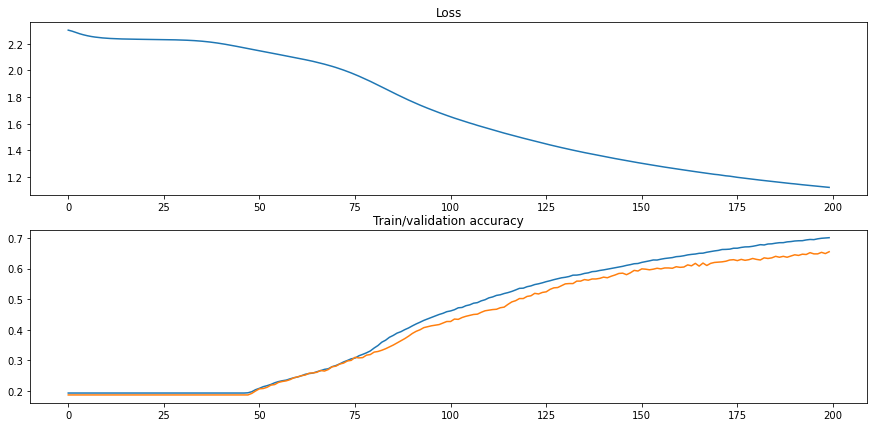

In [37]:
# Continue training best model with params: {'learning_rate': 0.01, 'reg_strength': 0.001, 'learning_rate_decay': 0.999}
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(best_classifier_history[0])
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(best_classifier_history[1])
plt.plot(best_classifier_history[2])

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [38]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.606000
